In [121]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from _plotly_future_ import v4_subplots
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import pickle 
from random import gauss
import seaborn as sns

In [2]:
def calculate_delta(S,K,r,d,Tau,sig):
    Z = (np.log(S/K) + (r-d+sig**2/2) * Tau) / (sig*np.sqrt(Tau))
    return  np.exp(-d*Tau) *norm.cdf(Z)

def calculate_gamma(S,K,r,d,Tau,sig):
    Z = (np.log(S/K) + (r-d+sig**2/2) * Tau) / (sig*np.sqrt(Tau))
    return np.exp(-d*Tau) * norm.pdf(Z)/(S*sig*np.sqrt(Tau))

def calculate_charm(S,K,r,d,Tau,sig):
    Z = (np.log(S/K) + (r-d+sig**2/2) * Tau) / (sig*np.sqrt(Tau))
    d2 = Z - sig*np.sqrt(Tau)
    A = d*np.exp(-d*Tau) * norm.cdf(Z)
    B = np.exp(-d*Tau) * norm.pdf(Z)* ((2*(r-d)*Tau) - d2*sig*np.sqrt(Tau))/(S*Tau*sig*np.sqrt(Tau))
    return A-B

In [3]:
# Monte Carlo Simulation of Stock Price
def generate_asset_price(S0, sig, r, dt):
    return S0 * np.exp((r - 0.5 * sig**2) * dt + sig * np.sqrt(dt) * gauss(0,1.0))

In [4]:
# Check delta and charm
# s = 111
# sig = 0.05
# r   = 0.1 
# T   = 1
# N_datapoints = 365
# dt = T/N_datapoints
# K       = 100 
# d       = 0.0 
# Tau = 1
# print('delta:', calculate_delta(s, K ,r, d, Tau, sig))
# print('charm:', calculate_charm(s, K ,r, d, Tau, sig))

# # print(s, K ,r, d, Tau, sig)

In [96]:
# Parameters
S0 = 36
sig = 0.2
r   = 0.06 
T   = 1
N_datapoints = 50
dt = T/N_datapoints
K       = 36
d       = 0.0 

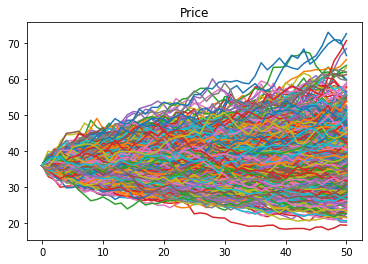

In [145]:
# Start from S0 = 100

for _ in range(1000):
    path=[S0]
    for i in range(T*N_datapoints):
        path.append(generate_asset_price(path[-1], sig, r, dt))
    path = np.array(path)
    plt.plot(path)
    plt.title("Price")

In [98]:
def calculate_call_price(S, K, r, d, Tau, sig):
    d1 = (np.log(S/K) + (r-d+(sig**2)/2) * Tau) / (sig*np.sqrt(Tau))
    d2 = d1 - sig*np.sqrt(Tau)
    price = S * np.exp(-(r - d) * Tau) * norm.cdf(d1) - K * np.exp(-r * Tau) * norm.cdf(d2)
    if price < 0:
        price = 0
    else:
        price=price
    return price

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in double_scalars



Text(0.5, 1.0, 'Call Price')

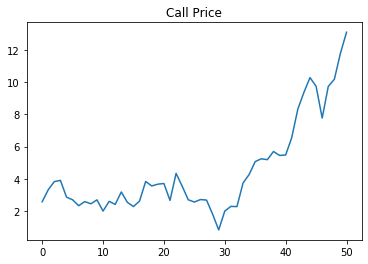

In [146]:
# Start from S0 = 100
call_price_path=[]
for i, s in enumerate(path):
    t = T - i * dt
    call_price_path.append(calculate_call_price(s, K, r, d, t, sig))
call_price_path = np.array(call_price_path)
plt.plot(call_price_path)
plt.title("Call Price")

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in double_scalars



Text(0.5, 1.0, 'Delta')

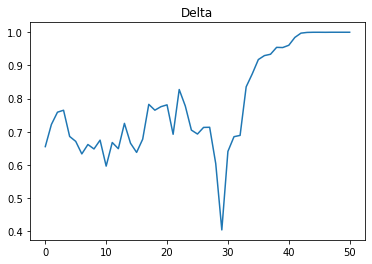

In [147]:
delta_path = []
for i, s in enumerate(path):
    t = T - i * dt
    delta_path.append(calculate_delta(s,K,r,d,t,sig))
delta_path = np.array(delta_path)
plt.plot(delta_path)
plt.title("Delta")

In [162]:
# calculate initial number of risk free bonds and stocks in portfolio
nS = delta_path[0] # Delta Hedging
nB = call_price_path[0] - nS * path[0] 

portfolio_value_path = [nB + delta_path[0] * path[0]]

for i in range(len(path)-1):
    portfolio_value_new = nB*np.exp(r*dt) + nS*path[i+1] # before rebalance
    portfolio_value_path.append(portfolio_value_new)
    
    print(
    "S:", round(path[i],2),
    "Port:", round(portfolio_value_path[i],2),
    "CP:", round(call_price_path[i],2),
    "HE:", round(call_price_path[i] - portfolio_value_path[i],2),
    "nS:", round(nS,2),
    "nB:", round(nB,2)
    )
    # Rebalance
    nS = delta_path[i+1]
    nB = portfolio_value_new - nS  * path[i+1]   

S: 36.0 Port: 2.58 CP: 2.58 HE: 0.0 nS: 0.66 nB: -21.01
S: 37.4 Port: 3.47 CP: 3.33 HE: -0.15 nS: 0.72 nB: -23.53
S: 38.27 Port: 4.07 CP: 3.83 HE: -0.24 nS: 0.76 nB: -24.98
S: 38.41 Port: 4.15 CP: 3.91 HE: -0.25 nS: 0.77 nB: -25.23
S: 36.7 Port: 2.82 CP: 2.87 HE: 0.06 nS: 0.69 nB: -22.37
S: 36.44 Port: 2.61 CP: 2.71 HE: 0.1 nS: 0.67 nB: -21.85
S: 35.77 Port: 2.13 CP: 2.34 HE: 0.21 nS: 0.63 nB: -20.53
S: 36.31 Port: 2.45 CP: 2.59 HE: 0.14 nS: 0.66 nB: -21.58
S: 36.1 Port: 2.28 CP: 2.46 HE: 0.18 nS: 0.65 nB: -21.12
S: 36.6 Port: 2.58 CP: 2.7 HE: 0.12 nS: 0.67 nB: -22.12
S: 35.28 Port: 1.67 CP: 2.01 HE: 0.34 nS: 0.6 nB: -19.39
S: 36.52 Port: 2.38 CP: 2.61 HE: 0.23 nS: 0.67 nB: -22.01
S: 36.22 Port: 2.15 CP: 2.42 HE: 0.27 nS: 0.65 nB: -21.36
S: 37.62 Port: 3.04 CP: 3.19 HE: 0.16 nS: 0.73 nB: -24.25
S: 36.54 Port: 2.23 CP: 2.55 HE: 0.32 nS: 0.67 nB: -22.1
S: 36.11 Port: 1.91 CP: 2.29 HE: 0.37 nS: 0.64 nB: -21.13
S: 36.79 Port: 2.32 CP: 2.63 HE: 0.31 nS: 0.68 nB: -22.62
S: 38.77 Port: 3.64 C

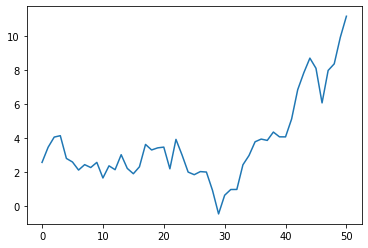

In [160]:
plt.plot(portfolio_value_path)

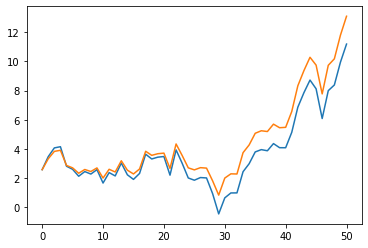

In [161]:
plt.plot(np.array(portfolio_value_path))
plt.plot(np.array(call_price_path))

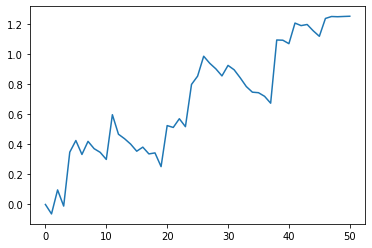

In [104]:
plt.plot(call_price_path - portfolio_value_path)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



Text(0.5, 1.0, 'Charm')

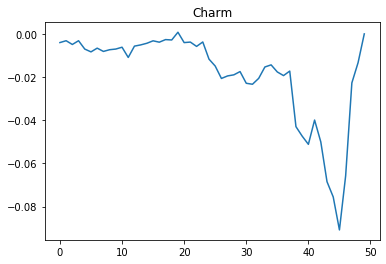

In [105]:
charm_path = []
for i, s in enumerate(path):
    t = T - i * dt
    charm_path.append(calculate_charm(s,K,r,d,t,sig))
charm_path = np.array(charm_path)
plt.plot(charm_path)
plt.title("Charm")

In [106]:
# level of charm adjustment
_lambda = 1

# calculate initial number of risk free bonds in portfolio
nS = delta_path[0] + _lambda * charm_path[0] # number of stock 
nB = call_price_path[0] - nS * path[0] 

portfolio_value_path_charmAdjusted = [nB + delta_path[0] * path[0]]

for i in range(len(path)-1):
    portfolio_value_new = nB*np.exp(r*dt) + nS * path[i+1] # BEFORE rebalance
    portfolio_value_path_charmAdjusted.append(portfolio_value_new)
    # Rebalance
    nS = delta_path[i+1] + _lambda * charm_path[i+1] * dt
    nB = portfolio_value_new - nS * path[i+1]

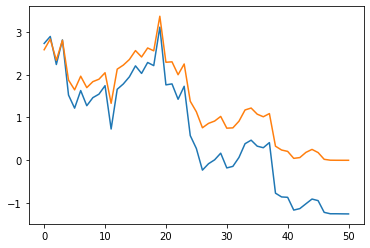

In [107]:
plt.plot(np.array(portfolio_value_path_charmAdjusted))
plt.plot(np.array(call_price_path))

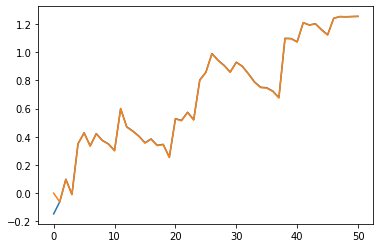

In [108]:
plt.plot(call_price_path - portfolio_value_path_charmAdjusted)
plt.plot(call_price_path - portfolio_value_path)

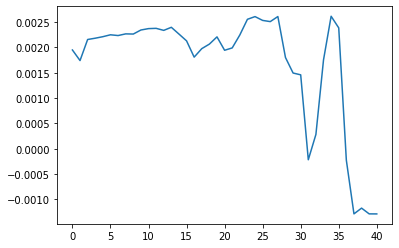

In [109]:
err0 = call_price_path - portfolio_value_path
err1 = call_price_path - portfolio_value_path_charmAdjusted
plt.plot((err1-err0)[10:])

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in double_scalars



Text(0.5, 1.0, 'Gamma')

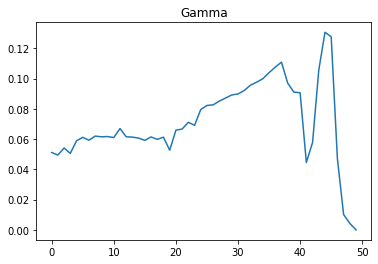

In [110]:
gamma_path = []
for i, s in enumerate(path):
    t = T - i * dt
    gamma_path.append(calculate_gamma(s,K,r,d,t,sig))
gamma_path = np.array(gamma_path)
plt.plot(gamma_path)
plt.title("Gamma")

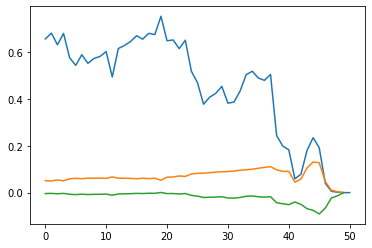

In [111]:
plt.plot(delta_path)
plt.plot(gamma_path)
plt.plot(charm_path)

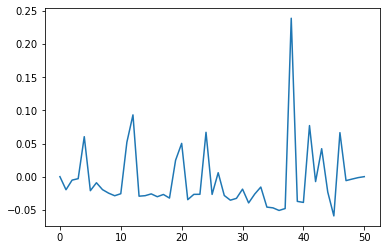

In [112]:
gamma_error_path = [0]
for i in range(len(path)-1):
    dS = path[i+1] - path[i]
    gamma_error = 0.5*gamma_path[i] * ((dS**2) - (sig**2)*(path[i]**2)*dt)
    gamma_error_path.append(gamma_error)
gamma_error_path = np.array(gamma_error_path)

plt.plot(gamma_error_path)

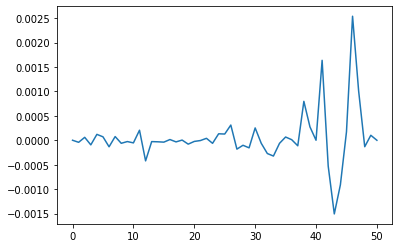

In [113]:
charm_error_path = [0]
for i in range(len(path)-1):
    dS = path[i+1] - path[i]
    charm_error = charm_path[i]*dt*dS
    charm_error_path.append(charm_error)
charm_error_path = np.array(charm_error_path)
plt.plot(charm_error_path)

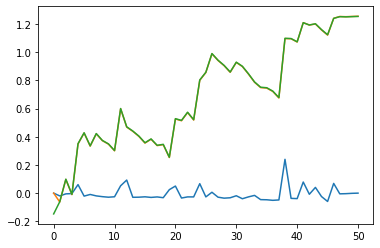

In [114]:
plt.plot(charm_error_path+ gamma_error_path)
plt.plot(err0)
plt.plot(err1)

## Get a distribution of Hedging error


In [118]:
def generate_hedging_error(S0, sig, r, T, N_datapoints, K, d, N_simulation, _lambda):
    dt = T/N_datapoints
    hedging_error = []
    for _ in range(N_simulation):
        # Generate Price Path
        path=[S0]
        for i in range(T*N_datapoints):
            path.append(generate_asset_price(path[-1], sig, r, dt))
        path = np.array(path)

        # Generate Call Price Path
        call_price_path=[]
        for i, s in enumerate(path):
            t = T - i * dt
            call_price_path.append(calculate_call_price(s, K, r, d, t, sig))
        call_price_path = np.array(call_price_path)
        
        # Generate Delta for Hedging
        delta_path = []
        for i, s in enumerate(path):
            t = T - i * dt
            delta_path.append(calculate_delta(s,K,r,d,t,sig))
        delta_path = np.array(delta_path)
        
        # Generate Charm for Hedging
        charm_path = []
        for i, s in enumerate(path):
            t = T - i * dt
            charm_path.append(calculate_charm(s,K,r,d,t,sig))
        charm_path = np.array(charm_path)
        
        # calculate initial number of risk free bonds in portfolio
        nS = delta_path[0] + _lambda * charm_path[0] # number of stock 
        nB = call_price_path[0] - nS * path[0] 

        portfolio_value_path = [nB + delta_path[0] * path[0]]

        for i in range(len(path)-1):
            portfolio_value_new = nB*np.exp(r*dt) + nS * path[i+1] # BEFORE rebalance
            portfolio_value_path_charmAdjusted.append(portfolio_value_new)
            # Rebalance
            nS = delta_path[i+1] + _lambda * charm_path[i+1] * dt
            nB = portfolio_value_new - nS * path[i+1]
        
        HE = portfolio_value_path[-1] - call_price_path[-1]
        hedging_error.append(HE)
    return np.array(hedging_error)

In [138]:
hedging_errors1 = generate_hedging_error(S0, sig, r, T, N_datapoints, K, d, 2000, _lambda)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



In [139]:
hedging_errors0 = generate_hedging_error(S0, sig, r, T, N_datapoints, K, d, 2000, 0)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



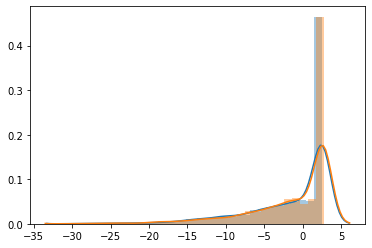

In [141]:
sns.distplot(hedging_errors0)
sns.distplot(hedging_errors1)

## Delta Hedging and Charm
Portfolio Value $\Pi$ at time $t$ is equal to
$$ \Pi = V - V_s S $$

In [ ]:
def call_price(S, K, r, d, Tau, sig):
    d1 = (np.log(S/K) + (r-d+sig**2/2) * Tau) / (sig*np.sqrt(Tau))
    d2 = d1 - sig*np.sqrt(Tau)
    
    price = S * np.exp(-(r - d) * Tau) * norm.cdf(d1) - K * np.exp(-r * Tau) * norm.cdf(d2)
    
    if price < 0:
        price = 0
    else:
        price=price
    return price

In [ ]:
call_price_path = []

for i, s in enumerate(path):
    Tau = T - (i * dt)
    call_price_path.append(call_price(S=s, K=K ,r=r, d=d, Tau=Tau, sig=sig))

plt.plot(call_price_path)


In [ ]:
plt.plot(np.array(path)-np.array(call_price_path))
print(K)

In [ ]:
# np.array(call_price_path)
# np.array(Nshares_short_path)*np.array(path)

In [ ]:
plt.plot((np.array(Nshares_short_path)*np.array(path)) - np.array(call_price_path))

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



           pnl
count 1,000.00
mean      0.18
std       0.07
min       0.00
25%       0.12
50%       0.15
75%       0.21
max       0.39


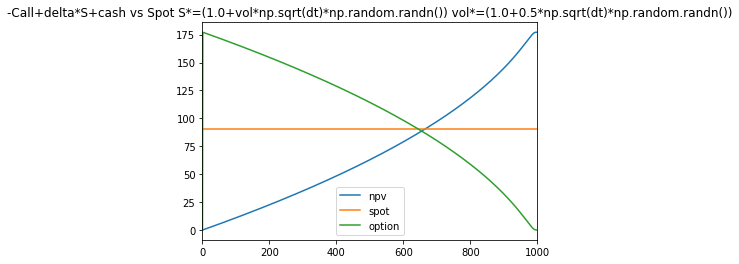

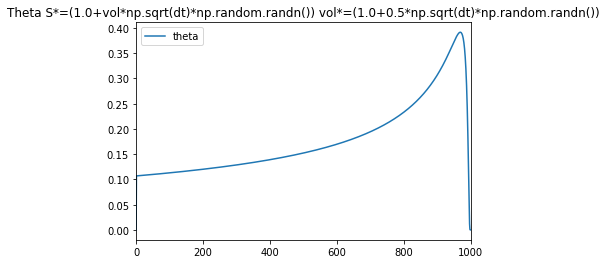

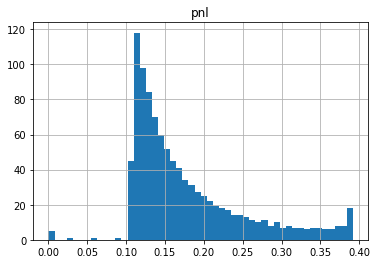

In [46]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 320)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:,.2f}'.format
from scipy.stats import norm
import matplotlib.pyplot as plt

def BlackScholes(tau, S, K, sigma):
    d1=np.log(S/K)/sigma/np.sqrt(tau)+0.5*sigma*np.sqrt(tau)
    d2=d1-sigma*np.sqrt(tau)
    npv=(S*norm.cdf(d1)-K*norm.cdf(d2))
    delta=norm.cdf(d1)
    gamma=norm.pdf(d1)/(S*sigma*np.sqrt(tau))
    vega=S*norm.pdf(d1)*np.sqrt(tau)
    theta=-.5*S*norm.pdf(d1)*sigma/np.sqrt(tau)
    return {'npv':npv,'delta':delta,'gamma':gamma,'vega':vega,'theta':theta}

class Call(object):
    def __init__(self,start,T,K,N):
        self.T=T
        self.K=K
        self.start=start  #day to sell   option
        self.N=N

    def calc(self,today,vol,S):
        if today<self.start:
            return {'delta':0,'npv':0,'vega':0,'gamma':0,'theta':0,'intrinsic':0}
        if today>self.T:
            return {'delta':0,'npv':0,'vega':0,'gamma':0,'theta':0,'intrinsic':0}
        if today==self.T:
            return {'delta':0,'npv':0,'vega':0,'gamma':0,'theta':0,'intrinsic':self.N*max(0,S-self.K)}
        tau=(self.T-today)/250.
        call=BlackScholes(tau, S, self.K, vol)
        return {'delta':self.N*call['delta'],'npv':self.N*call['npv'],'vega':self.N*call['vega'],'gamma':self.N*call['gamma'],'theta':self.N*call['theta'],'intrinsic':self.N*max(0,S-self.K)}

def deltahedge(Ndays,Sdynamics="S*=(1.0+vol*np.sqrt(dt)*np.random.randn())",volDynamics="vol=.30"):
    S=90.0
    Strike=100.0
    vol=.30
    columns=('spot','vol','shares','cash','option','npv','vega','gamma','theta','pnlPredict')
    df = pd.DataFrame([[S,vol,0,0,0,0,0,0,0,0]],columns=columns)
    dt=1/250.
    cash=0
    dayToSellCall=1
    maturityCall=Ndays-1
    call=Call(dayToSellCall,maturityCall,Strike,-10)# sell one call on dayToSellCall day
    for day in range(1,Ndays+1):
        exec(Sdynamics)
        exec(volDynamics)

        if day==dayToSellCall: #sell call
           callValue=call.calc(day,vol,S)
           cash-=callValue['npv']

        #delta hedge
        callValue=call.calc(day,vol,S)
        delta=callValue['delta']
        currentNumberShares=df.iloc[day-1].shares
        sharesBuy=-currentNumberShares-delta
        cash-=sharesBuy*S
        if day==maturityCall:
            cash+=call.calc(day,vol,S)['intrinsic'] #settle call

        gamma=callValue['gamma']
        theta=callValue['theta']
        dS=S-df.iloc[day-1].spot
        pnlPredict=0.5*gamma*dS*dS+theta*dt
        dfnew=pd.DataFrame([[S,vol,-delta,cash,-callValue['npv'],cash+callValue['npv']-delta*S,callValue['vega'],gamma,theta/250.,pnlPredict]],columns=columns)
        df=df.append(dfnew,ignore_index=True)

    df['pnl'] = df['npv'] - df['npv'].shift(1)
    df['vol']=100.0*df['vol']
    df['error']=df['pnl']-df['pnlPredict']
    df.set_value(dayToSellCall, "error", 0)
    #df.loc[:,['vol','spot']].plot(title='Spot and implied Volatility')
    df.loc[:,['npv','spot','option']].plot(title='-Call+delta*S+cash vs Spot {0} {1}'.format(Sdynamics,volDynamics))
    df.loc[:,['theta']].plot(title='Theta {0} {1}'.format(Sdynamics,volDynamics))
    df.loc[:,['pnl']].hist(bins=50)
    #df.loc[:,['error']].hist(bins=50)
    print(df.loc[:,['pnl']].describe())
    #print df

# deltahedge(1000)#constant vol
deltahedge(1000,volDynamics="vol*=(1.0+0.5*np.sqrt(dt)*np.random.randn())")#stochastic vol
# deltahedge(1000,Sdynamics="S=90") #consant OTM
# deltahedge(10000,Sdynamics="S=100") #consant ATM
# deltahedge(10000,Sdynamics="S=110")#consant ITM
# deltahedge(10000,Sdynamics="S+=S*dt") #growing stock
plt.show()